In [1]:
# -*- coding: utf-8 -*-
# doDMRG_MPO.py

# Imports

In [2]:
from dataclasses import dataclass
from ncon import ncon
import matplotlib.pyplot as plt
import numpy as np

# Main algorithm

In [3]:
def run_dmrg(
        A,
        ML,
        M,
        MR,
        maximum_bond_dimension: int,
        inplace = True,
        krylov_space_dimension:int = 4,
        max_iterations:int = 2,
        number_of_sweeps:int = 10,
        verbosity:int = 2,
):
    """
------------------------
by Glen Evenbly (c) for www.tensors.net, (v1.1) - last modified 19/1/2019
------------------------ Implementation of DMRG for a 1D chain with open boundaries, using the two-site update strategy. Each update is accomplished using a custom implementation of the Lanczos iteration to find (an approximation to) the ground state of the superblock Hamiltonian.
Input 'A' is containing the MPS tensors whose length is equal to that of the 1D lattice. The Hamiltonian is specified by an MPO with 'ML' and 'MR' the tensors at the left and right boundaries, and 'M' the bulk MPO tensor.
Automatically grow the MPS bond dimension to maximum dimension 'chi'. Outputs 'A' and 'B' are arrays of the MPS tensors in left and right orthogonal form respectively, while 'sWeight' is an array of the Schmidt coefficients across different lattice positions.
'energy_over_time' is a vector describing the energy at each update step.

Optional arguments:
`verbosity::Integer=2`: print data never [0], after each sweep [1], each step [2]
`inplace::Bool=true`: enable or disable tensor updates
`max_iterations::Integer=2`: number of iterations of Lanczos method for each diagonalization
`krylov_space_dimension::Integer=4`: maximum dimension of Krylov space in superblock diagonalization
"""

    ##### left-to-right 'warmup', put MPS in right orthogonal form
    bond_dimension_up = M.shape[2] #local dimension
    number_of_sites:int = len(A)
    print(number_of_sites)
    L = [0 for _ in range(number_of_sites)]
    L[0] = ML
    R = [0 for _ in range(number_of_sites)]
    R[number_of_sites-1] = MR

    for site_position in range(number_of_sites-1):
        bond_dimension_left = A[site_position].shape[0]
        bond_dimension_right = A[site_position].shape[2]

        utemp, stemp, vhtemp = np.linalg.svd(
            A[site_position].reshape(bond_dimension_left*bond_dimension_up,bond_dimension_right),
            full_matrices=False
        )

        A[site_position] = utemp.reshape(bond_dimension_left,bond_dimension_up,bond_dimension_right)
        A[site_position+1] = ncon(
            [
                np.diag(stemp) @ vhtemp,
                A[site_position+1]
            ], [
                [-1,1],
                [1,-2,-3]
            ]
        )/np.linalg.norm(stemp)
        L[site_position+1] = ncon(
            [
                L[site_position],
                M,
                A[site_position],
                np.conj(A[site_position])
            ],[
                [2,1,4],
                [2,-1,3,5],
                [4,5,-3],
                [1,3,-2]
            ]
        )

    bond_dimension_left = A[number_of_sites-1].shape[0]
    bond_dimension_right = A[number_of_sites-1].shape[2]

    utemp, stemp, vhtemp = np.linalg.svd(
        A[number_of_sites-1].reshape(bond_dimension_left*bond_dimension_up, bond_dimension_right),
        full_matrices=False
    )

    A[number_of_sites-1] = utemp.reshape(bond_dimension_left,bond_dimension_up,bond_dimension_right)
    sWeight = [0 for _ in range(number_of_sites+1)]
    sWeight[number_of_sites] = (np.diag(stemp) @ vhtemp) / np.linalg.norm(stemp)

    energy_over_time:np.array = np.array([])
    B = [0 for _ in range(number_of_sites)]
    for iteration in range(1, number_of_sweeps + 2):

        ##### final sweep is only for orthogonalization (disable updates)
        if iteration == number_of_sweeps+1:
            inplace = False
            verbosity = 0

        ###### Optimization sweep: right-to-left
        for site_position in range(number_of_sites-2,-1,-1):

            ##### two-site update
            bond_dimension_left = A[site_position].shape[0]
            bond_dimension_right = A[site_position+1].shape[2]

            try:
                psi_ground = ncon(
                    [
                        A[site_position],
                        A[site_position+1],
                        sWeight[site_position+2]
                    ],[
                        [-1,-2,1],
                        [1,-3,2],
                        [2,-4]
                    ]
                ).reshape(bond_dimension_left*bond_dimension_up*bond_dimension_up*bond_dimension_right)
            except Exception:
                pass

            if inplace:
                psi_ground, energy_over_time_temp = find_eig_using_lanczos(
                    psi_ground,
                    apply_mpo,
                    (L[site_position], M, M, R[site_position + 1]),
                    max_iterations=max_iterations,
                    krylov_space_dimension=krylov_space_dimension
                )
                energy_over_time = np.append(energy_over_time,energy_over_time_temp)

            utemp, stemp, vhtemp = np.linalg.svd(
                psi_ground.reshape(bond_dimension_left*bond_dimension_up,bond_dimension_up*bond_dimension_right),
                full_matrices=False
            )
            chi_temp = min(len(stemp), maximum_bond_dimension)
            A[site_position] = utemp[:,range(chi_temp)].reshape(bond_dimension_left,bond_dimension_up,chi_temp)
            sWeight[site_position+1] = np.diag(stemp[range(chi_temp)]/np.linalg.norm(stemp[range(chi_temp)]))
            B[site_position+1] = vhtemp[range(chi_temp),:].reshape(chi_temp,bond_dimension_up,bond_dimension_right)

            ##### new block Hamiltonian
            R[site_position] = ncon(
                [
                    M,
                    R[site_position+1],
                    B[site_position+1],
                    np.conj(B[site_position+1])
                ],[
                    [-1,2,3,5],
                    [2,1,4],
                    [-3,5,4],
                    [-2,3,1]
                ]
            )

            if verbosity == 2:
                print(f'Sweep: {iteration} of {number_of_sweeps}, Loc: {site_position},Energy: {energy_over_time[-1]:.5f}')

        ###### left boundary tensor
        bond_dimension_left = A[0].shape[0]
        bond_dimension_right = A[0].shape[2]

        Atemp = ncon([A[0],sWeight[1]],[[-1,-2,1],[1,-3]]).reshape(bond_dimension_left,bond_dimension_up*bond_dimension_right)
        utemp, stemp, vhtemp = np.linalg.svd(Atemp, full_matrices=False)
        B[0] = vhtemp.reshape(bond_dimension_left,bond_dimension_up,bond_dimension_right)
        sWeight[0] = utemp @ (np.diag(stemp)/np.linalg.norm(stemp))

        ###### Optimization sweep: left-to-right
        for site_position in range(number_of_sites-1):

            ##### two-site update
            bond_dimension_left = B[site_position].shape[0]
            bond_dimension_right = B[site_position+1].shape[2]

            psi_ground = ncon(
                [
                    sWeight[site_position],
                    B[site_position],
                    B[site_position+1]
                ],[
                    [-1,1],
                    [1,-2,2],
                    [2,-3,-4]
                ]
            ).reshape(bond_dimension_left*bond_dimension_up*bond_dimension_up*bond_dimension_right)

            if inplace:
                psi_ground, energy_over_time_temp = find_eig_using_lanczos(
                    psi_ground,
                    apply_mpo,
                    (L[site_position], M, M, R[site_position + 1]),
                    max_iterations=max_iterations,
                    krylov_space_dimension=krylov_space_dimension
                )
                energy_over_time = np.append(energy_over_time,energy_over_time_temp)

            utemp, stemp, vhtemp = np.linalg.svd(psi_ground.reshape(bond_dimension_left*bond_dimension_up,bond_dimension_up*bond_dimension_right), full_matrices=False)
            chi_temp = min(len(stemp), maximum_bond_dimension)
            A[site_position] = utemp[:,range(chi_temp)].reshape(bond_dimension_left,bond_dimension_up,chi_temp)
            sWeight[site_position+1] = np.diag(stemp[range(chi_temp)]/np.linalg.norm(stemp[range(chi_temp)]))
            B[site_position+1] = vhtemp[range(chi_temp),:].reshape(chi_temp,bond_dimension_up,bond_dimension_right)

            ##### new block Hamiltonian
            L[site_position+1] = ncon(
                [
                    L[site_position],
                    M,
                    A[site_position],
                    np.conj(A[site_position])
                ],[
                    [2,1,4],
                    [2,-1,3,5],
                    [4,5,-3],
                    [1,3,-2]
                ]
            )

            ##### display energy
            if verbosity == 2:
                print(f'Sweep: {iteration} of {number_of_sweeps}, Loc: {site_position},Energy: {energy_over_time[-1]:.5f}')

        ###### right boundary tensor
        bond_dimension_left = B[number_of_sites-1].shape[0]; bond_dimension_right = B[number_of_sites-1].shape[2]
        Atemp = ncon(
            [
                B[number_of_sites-1],
                sWeight[number_of_sites-1]
            ],[
                [1,-2,-3],
                [-1,1]
            ]
        ).reshape(bond_dimension_left*bond_dimension_up,bond_dimension_right)
        utemp, stemp, vhtemp = np.linalg.svd(Atemp, full_matrices=False)
        A[number_of_sites-1] = utemp.reshape(bond_dimension_left,bond_dimension_up,bond_dimension_right)
        sWeight[number_of_sites] = (stemp/np.linalg.norm(stemp))*vhtemp

        if verbosity == 1:
            print('Sweep: %d of %d, Energy: %12.12d, Bond dim: %d' % (iteration, number_of_sweeps, energy_over_time[-1], maximum_bond_dimension))

    return energy_over_time, A, sWeight, B


# Apply MPO

In [4]:
def apply_mpo(psi, L, M1, M2, R):
    """ function for applying MPO to state """

    return ncon(
        [
            psi.reshape(L.shape[2],M1.shape[3],M2.shape[3],R.shape[2]),
            L,
            M1,
            M2,
            R
        ],
        [
            [1,3,5,7],
            [2,-1,1],
            [2,4,-2,3],
            [4,6,-3,5],
            [6,-4,7]
        ]
    ).reshape(L.shape[2]*M1.shape[3]*M2.shape[3]*R.shape[2])


# Find eigenvalues

In [5]:
def find_eig_using_lanczos(
        psi_vector,
        linear_operator,
        linear_arguments,
        max_iterations:int = 2,
        krylov_space_dimension:int = 4
):
    """ Lanczos method for finding the smallest algebraic eigenvector of linear \
    operator defined as a function"""

    if np.linalg.norm(psi_vector) == 0:
        psi_vector = np.random.rand(len(psi_vector))

    psi = np.zeros([len(psi_vector), krylov_space_dimension + 1])
    A = np.zeros([krylov_space_dimension, krylov_space_dimension])

    for ik in range(max_iterations):

        psi[:,0] = psi_vector / max(np.linalg.norm(psi_vector), 1e-16)
        for ip in range(1, krylov_space_dimension + 1):

            psi[:,ip] = linear_operator(psi[:, ip - 1], *linear_arguments)

            for ig in range(ip):
                A[ip-1,ig] = np.dot(psi[:,ip],psi[:,ig])
                A[ig,ip-1] = np.conj(A[ip-1,ig])

            for ig in range(ip):
                psi[:,ip] = psi[:,ip] - np.dot(psi[:,ig],psi[:,ip])*psi[:,ig]
                psi[:,ip] = psi[:,ip] / max(np.linalg.norm(psi[:,ip]),1e-16)

        [dtemp,utemp] = np.linalg.eigh(A)
        psi_vector = psi[:, range(0, krylov_space_dimension)] @ utemp[:, 0]

    psi_vector = psi_vector / np.linalg.norm(psi_vector)
    dval = dtemp[0]

    return psi_vector, dval

# Setup experiment

## Set simulation options

In [6]:
@dataclass
class Options:
    dispon:int = 2 # level of output display
    inplace:bool = True # level of output display
    krydim:int = 4 # dimension of Krylov subspace
    maximum_bond_dimension:int = 16
    maxit:int = 2 # iterations of Lanczos method
    number_of_sites: int=50
    number_of_sweeps:int = 4 # number of DMRG sweeps

## Define Hamiltonian MPO (quantum XX model)

In [7]:
bond_dimention_up = 2
sP = np.sqrt(2)*np.array([[0, 0],[1, 0]])
sM = np.sqrt(2)*np.array([[0, 1],[0, 0]])
sX = np.array([[0, 1], [1, 0]])
sY = np.array([[0, -1j], [1j, 0]])
sZ = np.array([[1, 0], [0,-1]])
sI = np.array([[1, 0], [0, 1]])
M = np.zeros([4, 4, bond_dimention_up, bond_dimention_up])
M[0,0,:,:] = sI; M[3,3,:,:] = sI
M[0,1,:,:] = sM; M[1,3,:,:] = sP
M[0,2,:,:] = sP; M[2,3,:,:] = sM
ML = np.array([1,0,0,0]).reshape(4,1,1) # left MPO boundary
MR = np.array([0,0,0,1]).reshape(4,1,1) # right MPO boundary

## Initialize MPS tensors

In [8]:
A = [0 for x in range(Options.number_of_sites)]
A[0] = np.random.rand(1, bond_dimention_up, min(Options.maximum_bond_dimension, bond_dimention_up))
for k in range(1, Options.number_of_sites):
    A[k] = np.random.rand(
        A[k-1].shape[2],
        bond_dimention_up,
        min(min(Options.maximum_bond_dimension, A[k - 1].shape[2] * bond_dimention_up), bond_dimention_up ** (Options.number_of_sites - k - 1))
    )


## Do DMRG sweeps (2-site approach)

In [9]:
En1, A, sWeight, B = run_dmrg(
    A,
    ML,
    M,
    MR,
    Options.maximum_bond_dimension,
    number_of_sweeps= Options.number_of_sweeps,
    verbosity= Options.dispon,
    inplace= Options.inplace,
    max_iterations= Options.maxit,
    krylov_space_dimension= Options.krydim
)

50
Sweep: 1 of 4, Loc: 48,Energy: 38.78638
Sweep: 1 of 4, Loc: 47,Energy: 36.36234
Sweep: 1 of 4, Loc: 46,Energy: 31.25881
Sweep: 1 of 4, Loc: 45,Energy: 29.08234
Sweep: 1 of 4, Loc: 44,Energy: 26.35744
Sweep: 1 of 4, Loc: 43,Energy: 24.72319
Sweep: 1 of 4, Loc: 42,Energy: 22.65288
Sweep: 1 of 4, Loc: 41,Energy: 20.02008
Sweep: 1 of 4, Loc: 40,Energy: 17.98404
Sweep: 1 of 4, Loc: 39,Energy: 16.25024
Sweep: 1 of 4, Loc: 38,Energy: 13.61600
Sweep: 1 of 4, Loc: 37,Energy: 11.72545
Sweep: 1 of 4, Loc: 36,Energy: 9.32258
Sweep: 1 of 4, Loc: 35,Energy: 6.85036
Sweep: 1 of 4, Loc: 34,Energy: 3.99474
Sweep: 1 of 4, Loc: 33,Energy: 2.07507
Sweep: 1 of 4, Loc: 32,Energy: -0.44602
Sweep: 1 of 4, Loc: 31,Energy: -2.69669
Sweep: 1 of 4, Loc: 30,Energy: -4.68457
Sweep: 1 of 4, Loc: 29,Energy: -6.73900
Sweep: 1 of 4, Loc: 28,Energy: -9.47767
Sweep: 1 of 4, Loc: 27,Energy: -11.29799
Sweep: 1 of 4, Loc: 26,Energy: -13.59453
Sweep: 1 of 4, Loc: 25,Energy: -16.13525
Sweep: 1 of 4, Loc: 24,Energy: -18.324

## Increase bond dimention and reconverge

In [10]:
Options.maximum_bond_dimension = 32
En2, A, sWeight, B = run_dmrg(
    A,
    ML,
    M,
    MR,
    Options.maximum_bond_dimension,
    number_of_sweeps= Options.number_of_sweeps,
    verbosity= Options.dispon,
    inplace= Options.inplace,
    max_iterations= Options.maxit,
    krylov_space_dimension= Options.krydim
)

50
Sweep: 1 of 4, Loc: 48,Energy: -62.94428
Sweep: 1 of 4, Loc: 47,Energy: -62.94428
Sweep: 1 of 4, Loc: 46,Energy: -62.94428
Sweep: 1 of 4, Loc: 45,Energy: -62.94428
Sweep: 1 of 4, Loc: 44,Energy: -62.94428
Sweep: 1 of 4, Loc: 43,Energy: -62.94428
Sweep: 1 of 4, Loc: 42,Energy: -62.94428
Sweep: 1 of 4, Loc: 41,Energy: -62.94429
Sweep: 1 of 4, Loc: 40,Energy: -62.94430
Sweep: 1 of 4, Loc: 39,Energy: -62.94431
Sweep: 1 of 4, Loc: 38,Energy: -62.94433
Sweep: 1 of 4, Loc: 37,Energy: -62.94434
Sweep: 1 of 4, Loc: 36,Energy: -62.94437
Sweep: 1 of 4, Loc: 35,Energy: -62.94439
Sweep: 1 of 4, Loc: 34,Energy: -62.94443
Sweep: 1 of 4, Loc: 33,Energy: -62.94446
Sweep: 1 of 4, Loc: 32,Energy: -62.94450
Sweep: 1 of 4, Loc: 31,Energy: -62.94453
Sweep: 1 of 4, Loc: 30,Energy: -62.94458
Sweep: 1 of 4, Loc: 29,Energy: -62.94462
Sweep: 1 of 4, Loc: 28,Energy: -62.94467
Sweep: 1 of 4, Loc: 27,Energy: -62.94471
Sweep: 1 of 4, Loc: 26,Energy: -62.94477
Sweep: 1 of 4, Loc: 25,Energy: -62.94481
Sweep: 1 of 4

## Compare with exact results (computed from free fermions)

In [11]:
H = np.diag(np.ones(Options.number_of_sites - 1), k=1) + np.diag(np.ones(Options.number_of_sites - 1), k=-1)
D = np.linalg.eigvalsh(H)
EnExact = 2*sum(D[D < 0])

# Plot results

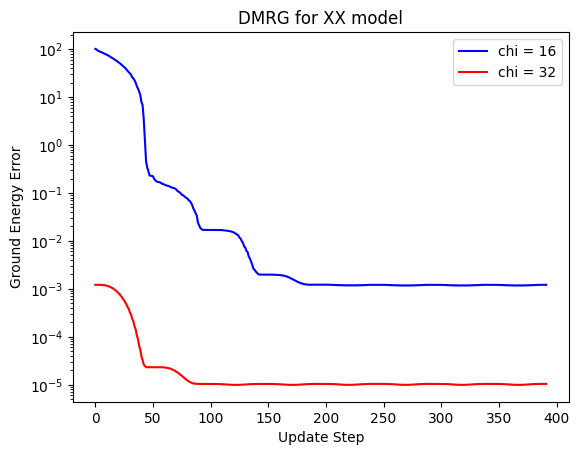

In [12]:
plt.figure(1)
plt.yscale('log')
plt.plot(range(len(En1)), En1 - EnExact, 'b', label="chi = 16")
plt.plot(range(len(En2)), En2 - EnExact, 'r', label="chi = 32")
plt.legend()
plt.title('DMRG for XX model')
plt.xlabel('Update Step')
plt.ylabel('Ground Energy Error')
plt.show()


# Compute 2-site reduced density matrices, local energy profile

In [13]:
rho_2 = [0 for _ in range(Options.number_of_sites - 1)]
local_hamiltonian = (np.real(
    np.kron(sX, sX) + np.kron(sY, sY)
)).reshape(2, 2, 2, 2)
energy_local = np.zeros(Options.number_of_sites - 1)

for k in range(Options.number_of_sites - 1):
    rho_2[k] = ncon(
        [
            A[k],
            np.conj(A[k]),
            A[k + 1],
            np.conj(A[k + 1]),
            sWeight[k + 2],
            sWeight[k+2]
        ], [
            [1,-3,2],
            [1,-1,3],
            [2,-4,4],
            [3,-2,5],
            [4,6],
            [5,6]
        ]
    )
    energy_local[k] = ncon(
        [
            local_hamiltonian,
            rho_2[k]
        ], [
            [1, 2, 3, 4],
            [1, 2, 3, 4]
        ]
    )

In [17]:
rho_2

[array([[[[ 6.97017551e-02,  9.85478230e-07],
          [-1.15341776e-06,  9.54370578e-08]],
 
         [[ 9.85478230e-07,  4.30298174e-01],
          [-4.24615381e-01, -1.15369048e-06]]],
 
 
        [[[-1.15341776e-06, -4.24615381e-01],
          [ 4.30298254e-01,  9.78525193e-07]],
 
         [[ 9.54370578e-08, -1.15369048e-06],
          [ 9.78525193e-07,  6.97018175e-02]]]]),
 array([[[[ 1.85257591e-01, -1.38074771e-06],
          [ 9.83408195e-07,  7.70501586e-08]],
 
         [[-1.38074771e-06,  3.14742418e-01],
          [-2.54445257e-01,  9.80595229e-07]]],
 
 
        [[[ 9.83408195e-07, -2.54445257e-01],
          [ 3.14742337e-01, -1.39028155e-06]],
 
         [[ 7.70501586e-08,  9.80595229e-07],
          [-1.39028155e-06,  1.85257654e-01]]]]),
 array([[[[ 1.17366628e-01,  1.29621106e-06],
          [-1.38276498e-06,  1.80780085e-07]],
 
         [[ 1.29621106e-06,  3.82633301e-01],
          [-3.64188611e-01, -1.38826428e-06]]],
 
 
        [[[-1.38276498e-06, -3.64188611